# regions and networks

In [149]:
from gradecc.load_data.ts import timeseries
ts = timeseries(subject=2, epoch='baseline')
region_names = ts.columns.tolist()
# region_names is sorted as plot brain needs
len(region_names)

1040

number of regions in cortex and subcortex

In [150]:
import pandas as pd

labels = pd.Series(region_names)
labels = labels.apply(lambda x: x.split(' ')[0]+'SubC' if ' ' in x   # subcortical regions
            else x[10:].split('_')[1]+'Cort')    # cortical regions
labels = labels.rename('label')
assert labels.shape[0] == 1040
print(labels.unique())

['VisCort' 'SomMotCort' 'DorsAttnCort' 'SalVentAttnCort' 'LimbicCort'
 'ContCort' 'DefaultCort' 'LeftSubC' 'RightSubC' 'VermisSubC']


show brain plot for a few of the Yeo's networks

In [109]:
# setup brain plot
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
import nibabel
from surfplot import Plot

fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


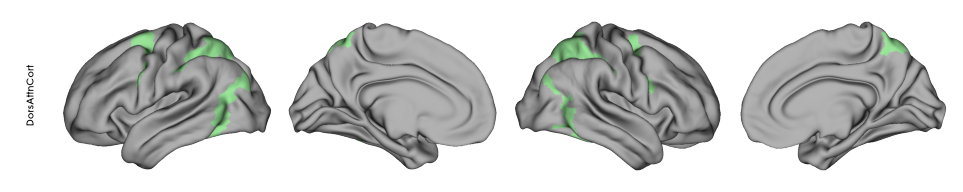

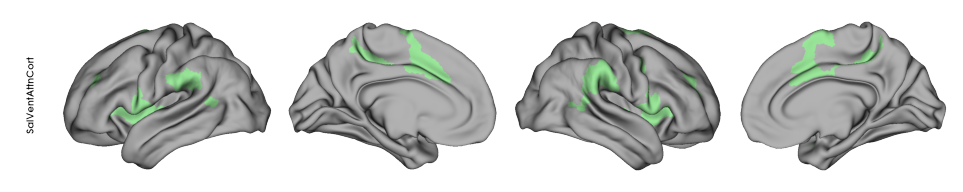

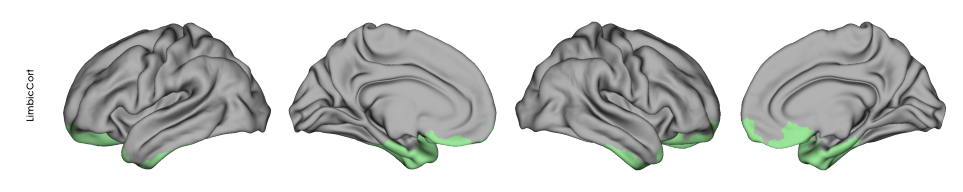

In [111]:
for l in labels.unique()[2:5]:
    data = labels == l
    data = map_to_labels(data, vertices, mask=(vertices != 0))
    p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300), label_text=[l])
    p.add_layer(data, cbar=False, cmap='Accent')
    _ = p.build()

# find ROIs
hand-picked regions of interest based on the figure

![selected ROIs](./ROIs-annotated.png)

In [113]:
pd.Series(region_names)[pd.Series(region_names).str.startswith('7Networks_LH_DorsAttn')]
data = pd.Series(region_names).str.startswith('7Networks_LH_DorsAttn_FEF_5')
# data = pd.Series(region_names)==('7Networks_LH_Default_PFC_4')
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=False, cmap='bwr')
# _ = p.build()

In [114]:
seeds = ['7Networks_LH_Default_PFC_19', '7Networks_RH_Default_PFCdPFCm_14', '7Networks_LH_Vis_33',
         '7Networks_RH_Default_PFCv_6', '7Networks_RH_Default_PFCdPFCm_15', '7Networks_LH_SomMot_57',
         '7Networks_RH_Limbic_TempPole_1', '7Networks_LH_Limbic_TempPole_9', '7Networks_RH_Vis_45',
         '7Networks_LH_Default_Temp_15', '7Networks_LH_Default_PFC_31', '7Networks_LH_Default_PFC_4',
         '7Networks_LH_DorsAttn_FEF_5']

let's take one as a sample seed ROI

# calculate correlation for seeds
for a seed ROI, calculate connectivity during epochs

In [115]:
EPOCHS = ['baseline', 'early', 'late']
SUBJECTS_INT = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 41, 44, 45, 46]
len(SUBJECTS_INT)

38

we are ignoring 'rest' epoch. all calculation on these 38 subjects.

In [120]:
from scipy.stats import pearsonr
from tqdm import tqdm
tqdm.pandas()

In [124]:
list0 = []
for seed in tqdm(seeds):
    list1 = []
    for e in EPOCHS:
        list2 = []
        for subj in SUBJECTS_INT:
            ts = timeseries(subj, e)
            seed_ts = ts[seed]
            # we neglect pvalue of whether r is significant
            r = [pearsonr(seed_ts, ts[idx])[0] for idx in ts]   # pearsonr()[0] is rvalue
            r = pd.DataFrame({'r': r}, index=ts.columns)
            r.rename_axis('region', inplace=True)
            r = pd.concat([r], keys=[subj], names=['subject'])
            list2.append(r)
        r = pd.concat(list2, 0)
        r = pd.concat([r], keys=[e], names=['epoch'])   # adds epoch as lower level index
        list1.append(r)

    dfr = pd.concat(list1, 0)
    dfr = pd.concat([dfr], keys=[seed], names=['seed_region'])
    list0.append(dfr)

dfr = pd.concat(list0, 0)

100%|██████████| 13/13 [04:42<00:00, 21.71s/it]


In [243]:
dfr.head()

r
seed_region                 epoch    subject region                      
7Networks_LH_Default_PFC_19 baseline 1       7Networks_LH_Vis_1  0.127065
                                             7Networks_LH_Vis_2 -0.112173
                                             7Networks_LH_Vis_3  0.350969
                                             7Networks_LH_Vis_4  0.098825
                                             7Networks_LH_Vis_5  0.207375

# average over subjects
average seed connectivity over all subjects during each epoch.

In [135]:
dfr_mean = dfr.groupby(level=[0, 1, 3]).mean()
dfr_mean.head()

r
seed_region                 epoch    region                            
7Networks_LH_Default_PFC_19 baseline 7Networks_LH_Cont_Cing_1  0.061146
                                     7Networks_LH_Cont_Cing_2 -0.035186
                                     7Networks_LH_Cont_Cing_3 -0.066176
                                     7Networks_LH_Cont_Cing_4 -0.031134
                                     7Networks_LH_Cont_Cing_5  0.108217

plot mean connectivity of one seed during one epoch

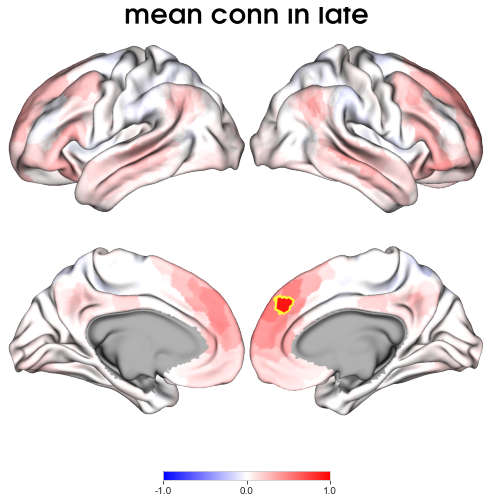

In [153]:
seed = seeds[4]
e = 'late'

data = dfr_mean.loc[seed, e]
data = data.loc[pd.Series(region_names)]['r']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 800),
         label_text={'top': ['mean conn in '+e]})
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-1, 1))
# seed region outlined
data = map_to_labels(pd.Series(region_names)==seed, vertices, mask=(vertices != 0))
p.add_layer(data, cbar=False, as_outline=True)
_ = p.build()

# shift in seed connectivity
using pairwise t-tests between epochs, we can calculate statistical diff for seed region-region link.

In [142]:
import pingouin as pg

dfp = dfr.reset_index([1,2]).groupby(level=[0,1]).progress_apply(pg.pairwise_ttests, dv='r', between='epoch',
                                            subject='subject', padjust='fdr_bh')
dfp.reset_index(level=2, inplace=True)
dfp = dfp.set_index([dfp.index, 'A', 'B']).reorder_levels([0, 2, 3, 1])

100%|██████████| 13520/13520 [02:34<00:00, 87.26it/s]


In [143]:
dfp[['T', 'p-unc', 'p-corr']].head()

T  \
seed_region                 A        B     region                               
7Networks_LH_Default_PFC_19 baseline early 7Networks_LH_Cont_Cing_1 -1.276783   
                                     late  7Networks_LH_Cont_Cing_1 -0.682928   
                            early    late  7Networks_LH_Cont_Cing_1  0.700850   
                            baseline early 7Networks_LH_Cont_Cing_2 -1.721901   
                                     late  7Networks_LH_Cont_Cing_2  0.487804   

                                                                        p-unc  \
seed_region                 A        B     region                               
7Networks_LH_Default_PFC_19 baseline early 7Networks_LH_Cont_Cing_1  0.205671   
                                     late  7Networks_LH_Cont_Cing_1  0.496785   
                            early    late  7Networks_LH_Cont_Cing_1  0.485595   
                            baseline early 7Networks_LH_Cont_Cing_2  0.089265   
                                     late  7Networks_LH_Cont_Cing_2  0.627131   

                                                                       p-corr  
seed_region                 A        B     region                              
7Networks_LH_Default_PFC_19 baseline early 7Networks_LH_Cont_Cing_1  0.496785  
                                     late  7Networks_LH_Cont_Cing_1  0.496785  
                            early    late  7Networks_LH_Cont_Cing_1  0.496785  
                            baseline early 7Networks_LH_Cont_Cing_2  0.133898  
                                     late  7Networks_LH_Cont_Cing_2  0.627131

## baseline to ealy
this is how connectivity (pearson corr coef) shift for one seed region outlined in yellow.

for example, seed region conn shift; baseline to early t-tests; masked with corrected p value

In [207]:
def plot_seed_shift(seed_region, pair, masked=False):
    assert len(pair) == 2 and pair[0] in EPOCHS and pair[1] in EPOCHS

    idx = (seed_region, *pair)
    data = dfp.loc[idx] # connectivity shift for the seed region
    if masked:  data = data.apply(lambda row: row['T'] if row['p-corr'] < 0.05 else None, axis=1)
    else:   data = data['T']
    data = data.loc[pd.Series(region_names)]
    data = map_to_labels(data, vertices, mask=(vertices != 0))

    p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
    p.add_layer(data, cbar=True, cmap='bwr', color_range=(-4, 4))
    data = map_to_labels(pd.Series(region_names)==seed_region, vertices, mask=(vertices != 0))
    p.add_layer(data, cbar=False, as_outline=True)  # seed region outlined
    fig = p.build()
    masked = 'masked' if masked else 'notMasked'
    fig.savefig('./plots/' + seed_region[10:] + '__' + pair[0]+'2'+pair[1] + '__' + masked + '.png')

In [ ]:
# [plot_seed_shift(seed, pair, masked)
#  for seed in seeds
#  for pair in [('baseline', 'early'), ('early', 'late')]
#  for masked in [True, False]]